# QuantGAN Example Usage

This notebook demonstrates how to use QuantGAN to generate synthetic time series data.

## Steps:
1. Generate mock stochastic exponential time series data (Geometric Brownian Motion)
2. Preprocess data using preprocessing utilities (convert to log returns)
3. Train QuantGAN model (assumes data is already log returns)
4. Generate synthetic samples


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

project_root = Path().resolve().parents[0].parents[0]
sys.path.append(str(project_root))

from src.models.non_parametric.quant_gan import QuantGAN
from src.utils.preprocessing_utils import (
    create_dataloaders,
    preprocess_data
)

from src.utils.configs_utils import get_dataset_cfgs

## Step 1: SPXUSD Data


Preprocessing data for spxusd

Preprocessed data shapes:
Train: torch.Size([233061, 52])
Valid: torch.Size([29133, 52])
Test: torch.Size([29133, 52])


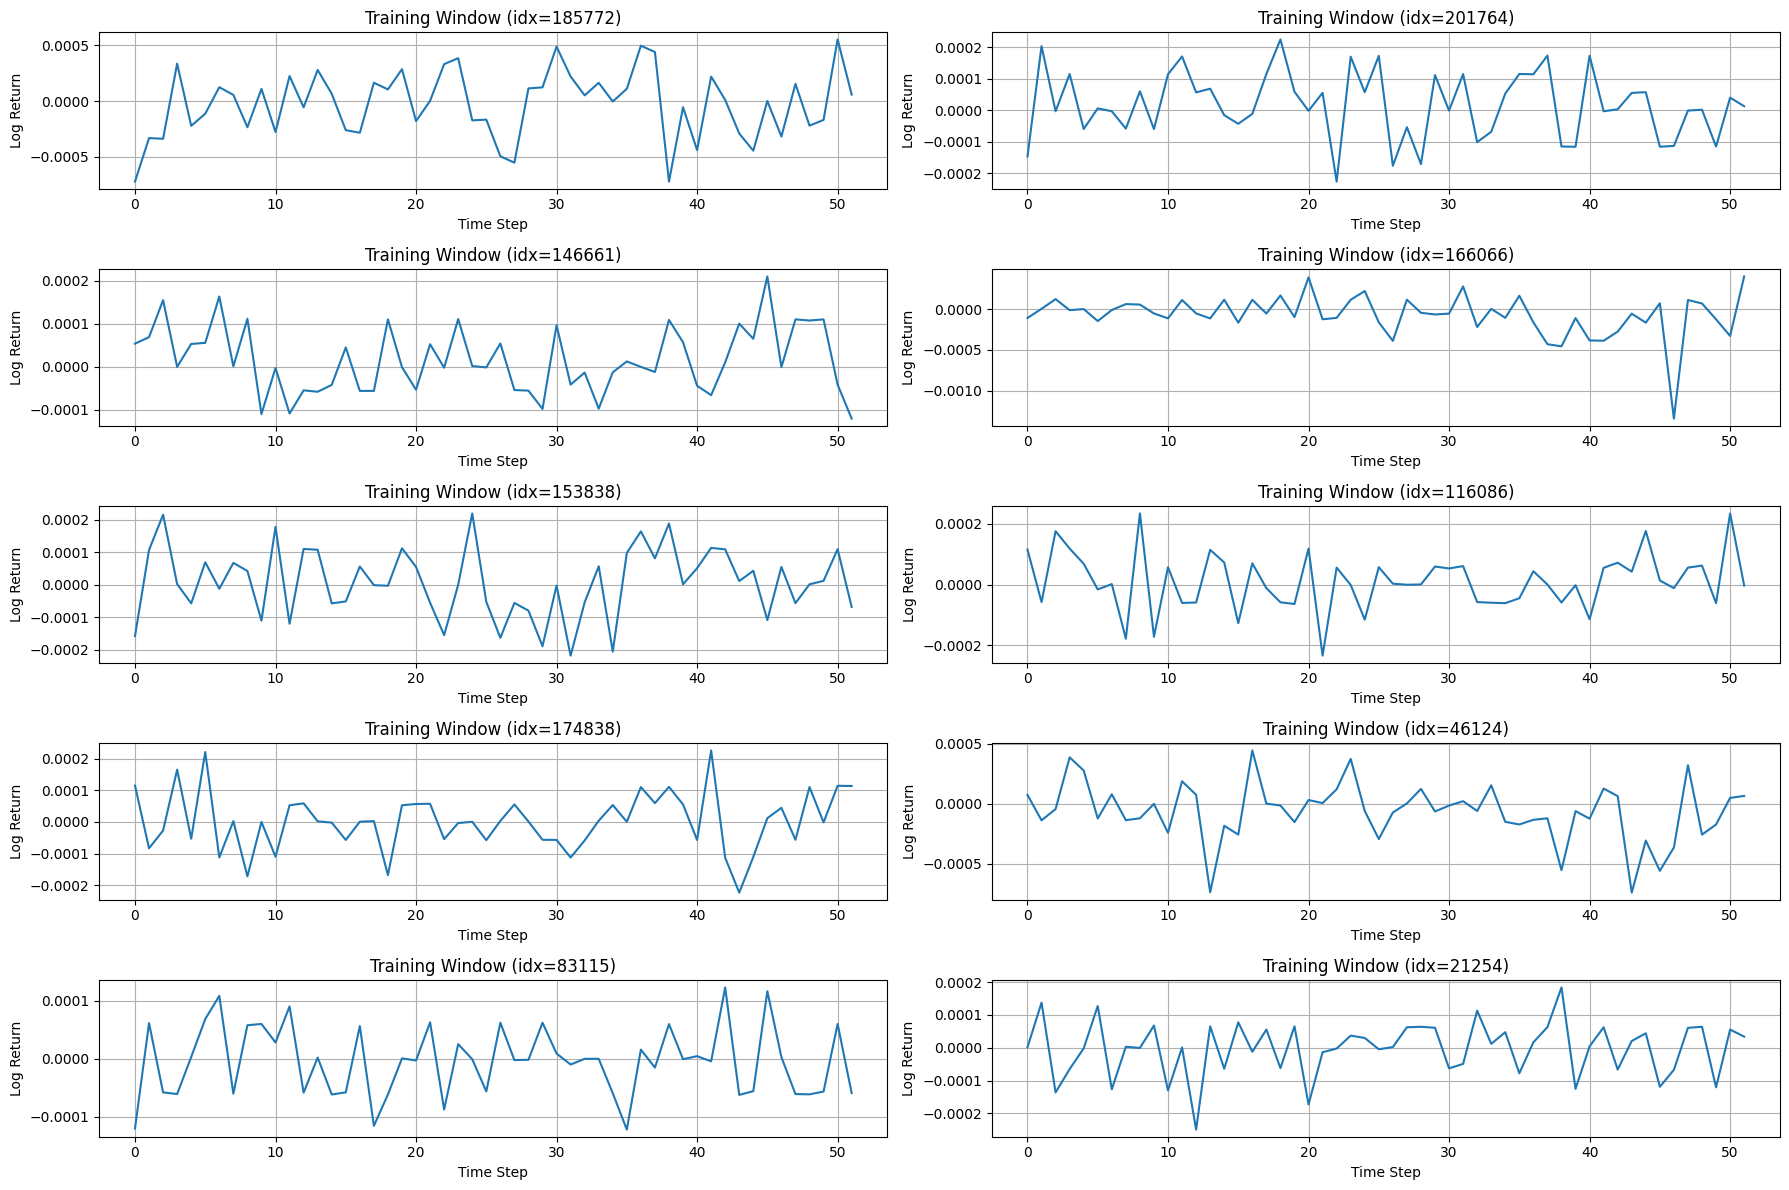

In [2]:

seq_length = 52
non_parametric_dataset_cfgs, _ = get_dataset_cfgs()
non_parametric_dataset_cfgs["seq_length"] = seq_length

train_data, valid_data, test_data, train_initial, valid_initial, test_initial = preprocess_data(
    non_parametric_dataset_cfgs
)

print(f"\nPreprocessed data shapes:")
print(f"Train: {train_data.shape}")
print(f"Valid: {valid_data.shape}")
print(f"Test: {test_data.shape}")

# Randomly choose 4 distinct indices
idx = np.random.choice(len(train_data), size=10, replace=False)

# Visualize randomly sampled training windows
fig, axes = plt.subplots(5, 2, figsize=(18, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    window = train_data[idx[i]].numpy()
    ax.plot(window)
    ax.set_title(f"Training Window (idx={idx[i]})")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Log Return")
    ax.grid(True)

plt.tight_layout()
plt.show()


## Step 3: Create DataLoaders

Create PyTorch DataLoaders for training.


In [3]:
# Create DataLoaders
train_data = train_data[:3000]
batch_size = 64
train_loader, valid_loader, test_loader = create_dataloaders(
    train_data=train_data,
    valid_data=valid_data,
    test_data=test_data,
    batch_size=batch_size,
    train_initial=train_initial,
    valid_initial=valid_initial,
    test_initial=test_initial,
    num_workers=0,
    pin_memory=False
)


print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Check batch shape
sample_batch, sample_initial = next(iter(train_loader))
print(f"\nBatch shape: {sample_batch.shape}")
print(f"Initial values shape: {sample_initial.shape}")


Number of training batches: 47
Number of validation batches: 456
Number of test batches: 456

Batch shape: torch.Size([64, 52])
Initial values shape: torch.Size([64])


## Step 4: Initialize and Train QuantGAN

Create QuantGAN model and train it on the preprocessed data.

**Note:** QuantGAN uses Temporal Convolutional Networks (TCN) with WGAN-style training. It assumes input data is already log returns.


In [4]:
# Initialize QuantGAN model

model = QuantGAN(
    seq_len=seq_length
)

print(f"QuantGAN model initialized on device: {model.device}")
print(f"Model parameters:")

/Users/eddisonpham/Projects/Unified-benchmark-for-SDGFTS/.venv/lib/python3.13/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


QuantGAN model initialized on device: cpu
Model parameters:


Starting QuantGAN training...
Note: QuantGAN uses TCN architecture with WGAN-style training.


QuantGAN Training:   0%|                                                     | 0/10 [00:00<?, ?it/s]

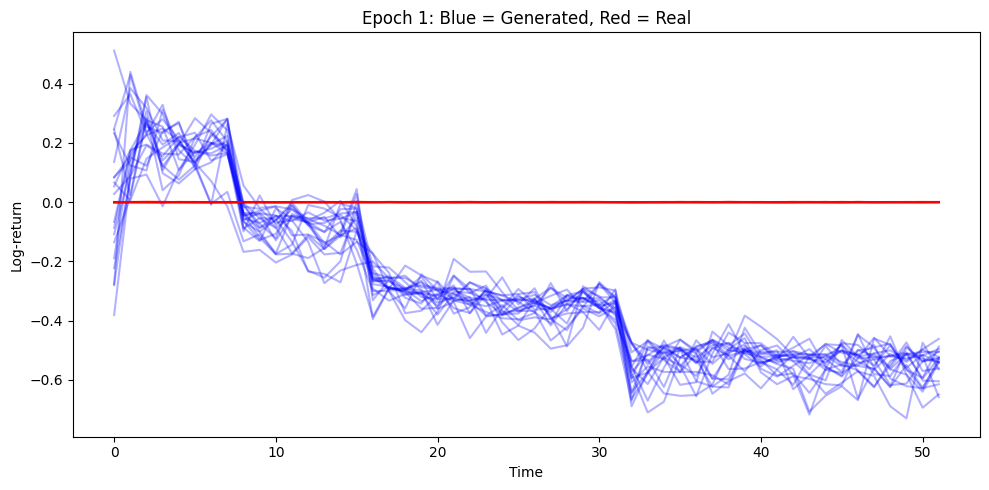

QuantGAN Training:  10%|████▍                                       | 1/10 [03:04<27:39, 184.43s/it]

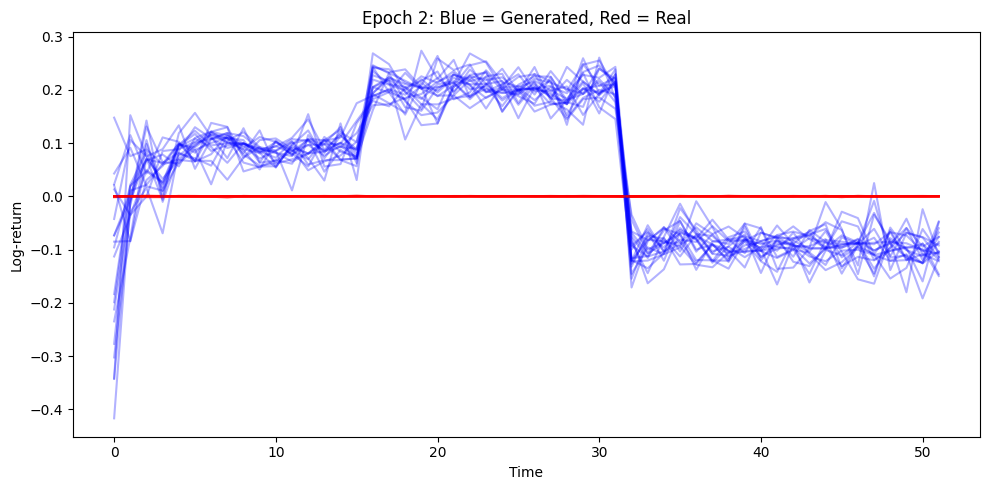

QuantGAN Training:  20%|████████▊                                   | 2/10 [06:05<24:21, 182.64s/it]

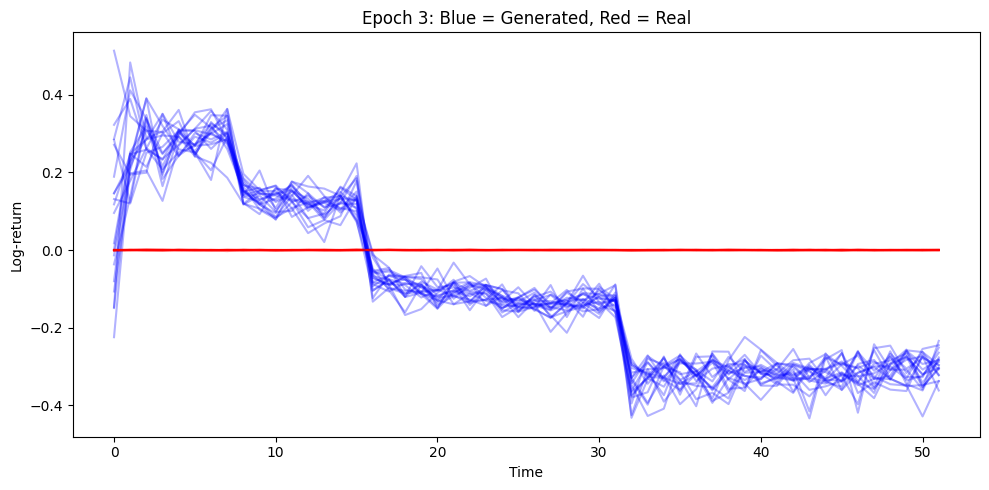

QuantGAN Training:  30%|█████████████▏                              | 3/10 [09:04<21:06, 180.96s/it]

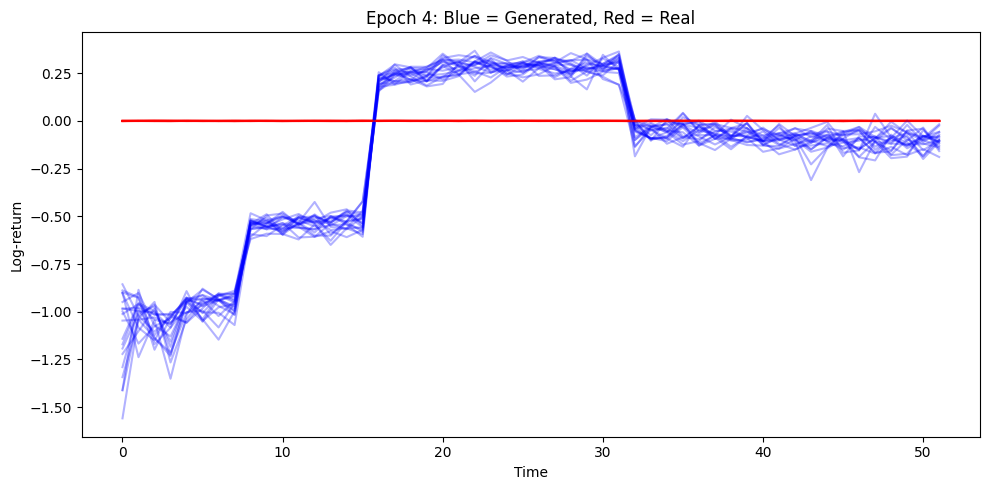

QuantGAN Training:  40%|█████████████████▌                          | 4/10 [12:02<17:58, 179.83s/it]

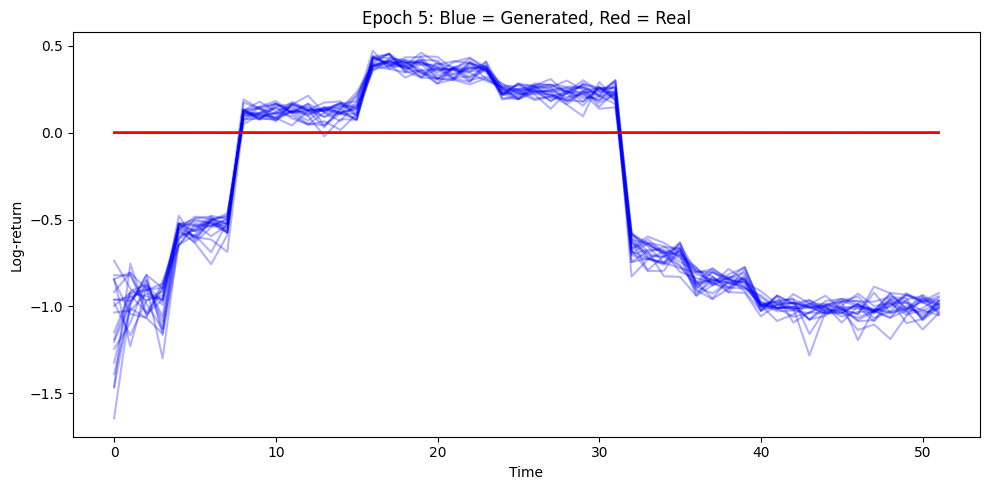

QuantGAN Training:  50%|██████████████████████                      | 5/10 [15:02<14:59, 179.80s/it]

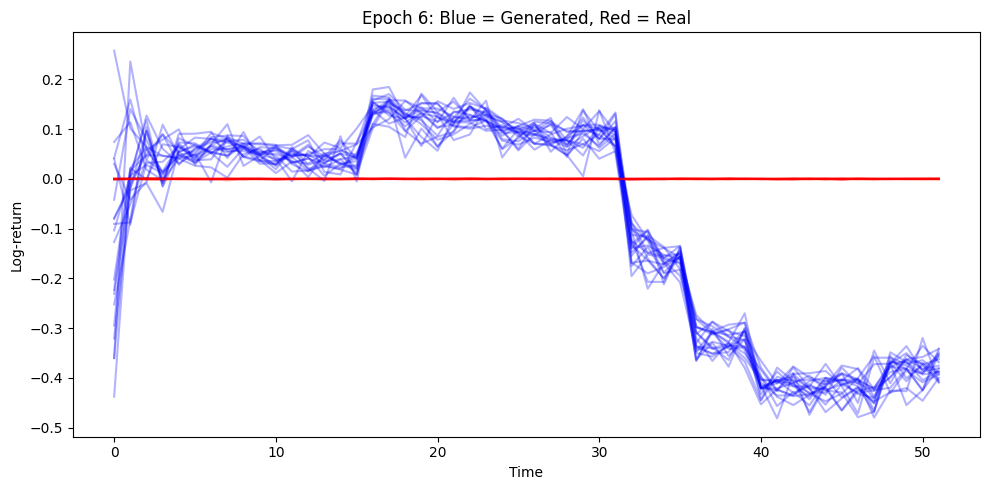

QuantGAN Training:  60%|██████████████████████████▍                 | 6/10 [18:06<12:04, 181.10s/it]

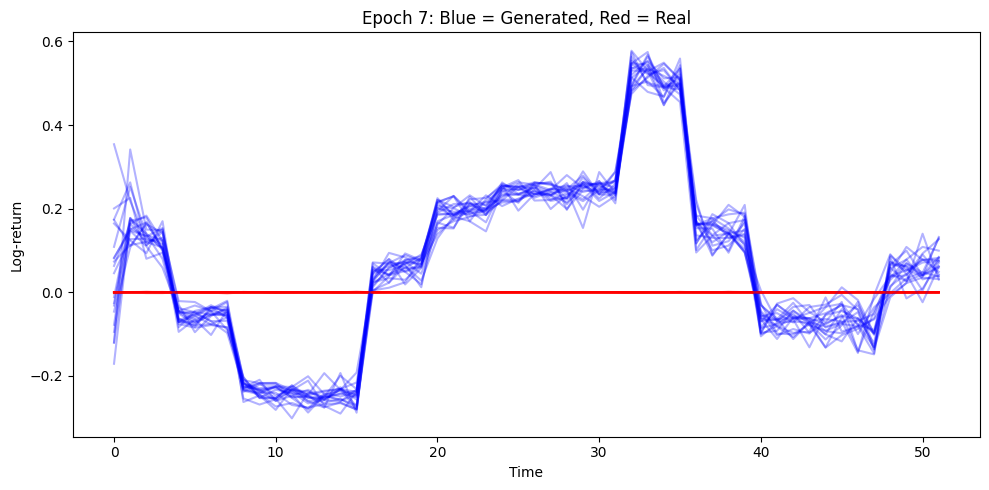

QuantGAN Training:  70%|██████████████████████████████▊             | 7/10 [21:15<09:10, 183.62s/it]

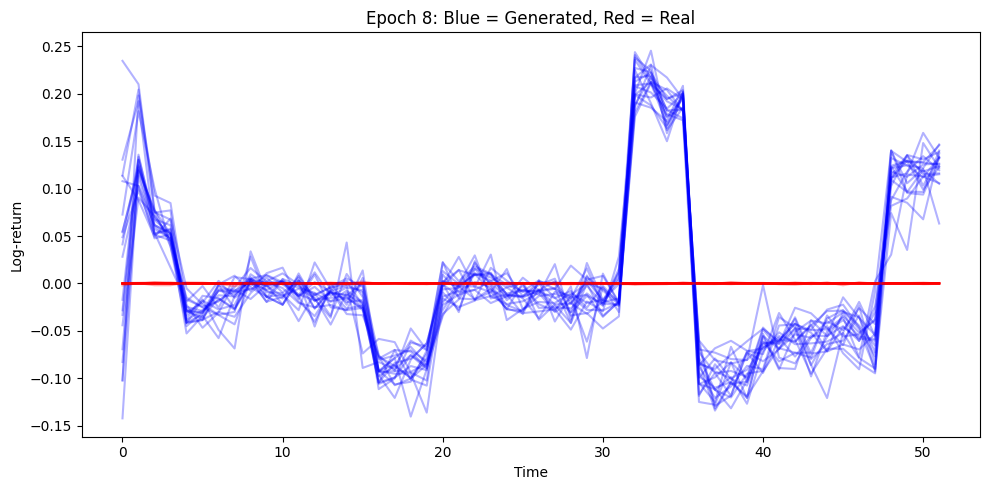

QuantGAN Training:  80%|███████████████████████████████████▏        | 8/10 [24:25<06:11, 185.73s/it]

In [ ]:
# Train the model
print("Starting QuantGAN training...")
print("Note: QuantGAN uses TCN architecture with WGAN-style training.")
model.fit(
    data_loader=train_loader,
    num_epochs=10
)
print("\nTraining complete!")

## Step 5: Generate Synthetic Samples

Generate synthetic time series samples using the trained model.


In [ ]:
# Generate synthetic samples
num_samples = 20
generation_length = seq_length

print(f"Generating {num_samples} synthetic samples of length {generation_length}...")
generated_samples = model.generate(
    num_samples=num_samples,
    generation_length=generation_length,
    seed=123
)
print(generated_samples.shape)

print(f"Generated samples shape: {generated_samples.shape}")
print(f"Generated samples stats: mean={generated_samples.mean():.6f}, std={generated_samples.std():.6f}")

# Compare with real data
print(f"\nReal data stats: mean={train_data.mean():.6f}, std={train_data.std():.6f}")


Generating 20 synthetic samples of length 52...
torch.Size([20, 52])
Generated samples shape: torch.Size([20, 52])
Generated samples stats: mean=-0.001746, std=0.001613

Real data stats: mean=-0.000000, std=0.000379


## Step 6: Visualize Results

Compare generated samples with real training data.


/var/folders/5g/xd1_vnlj2zg4df463t644sgw0000gn/T/ipykernel_4425/1961166357.py:61: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


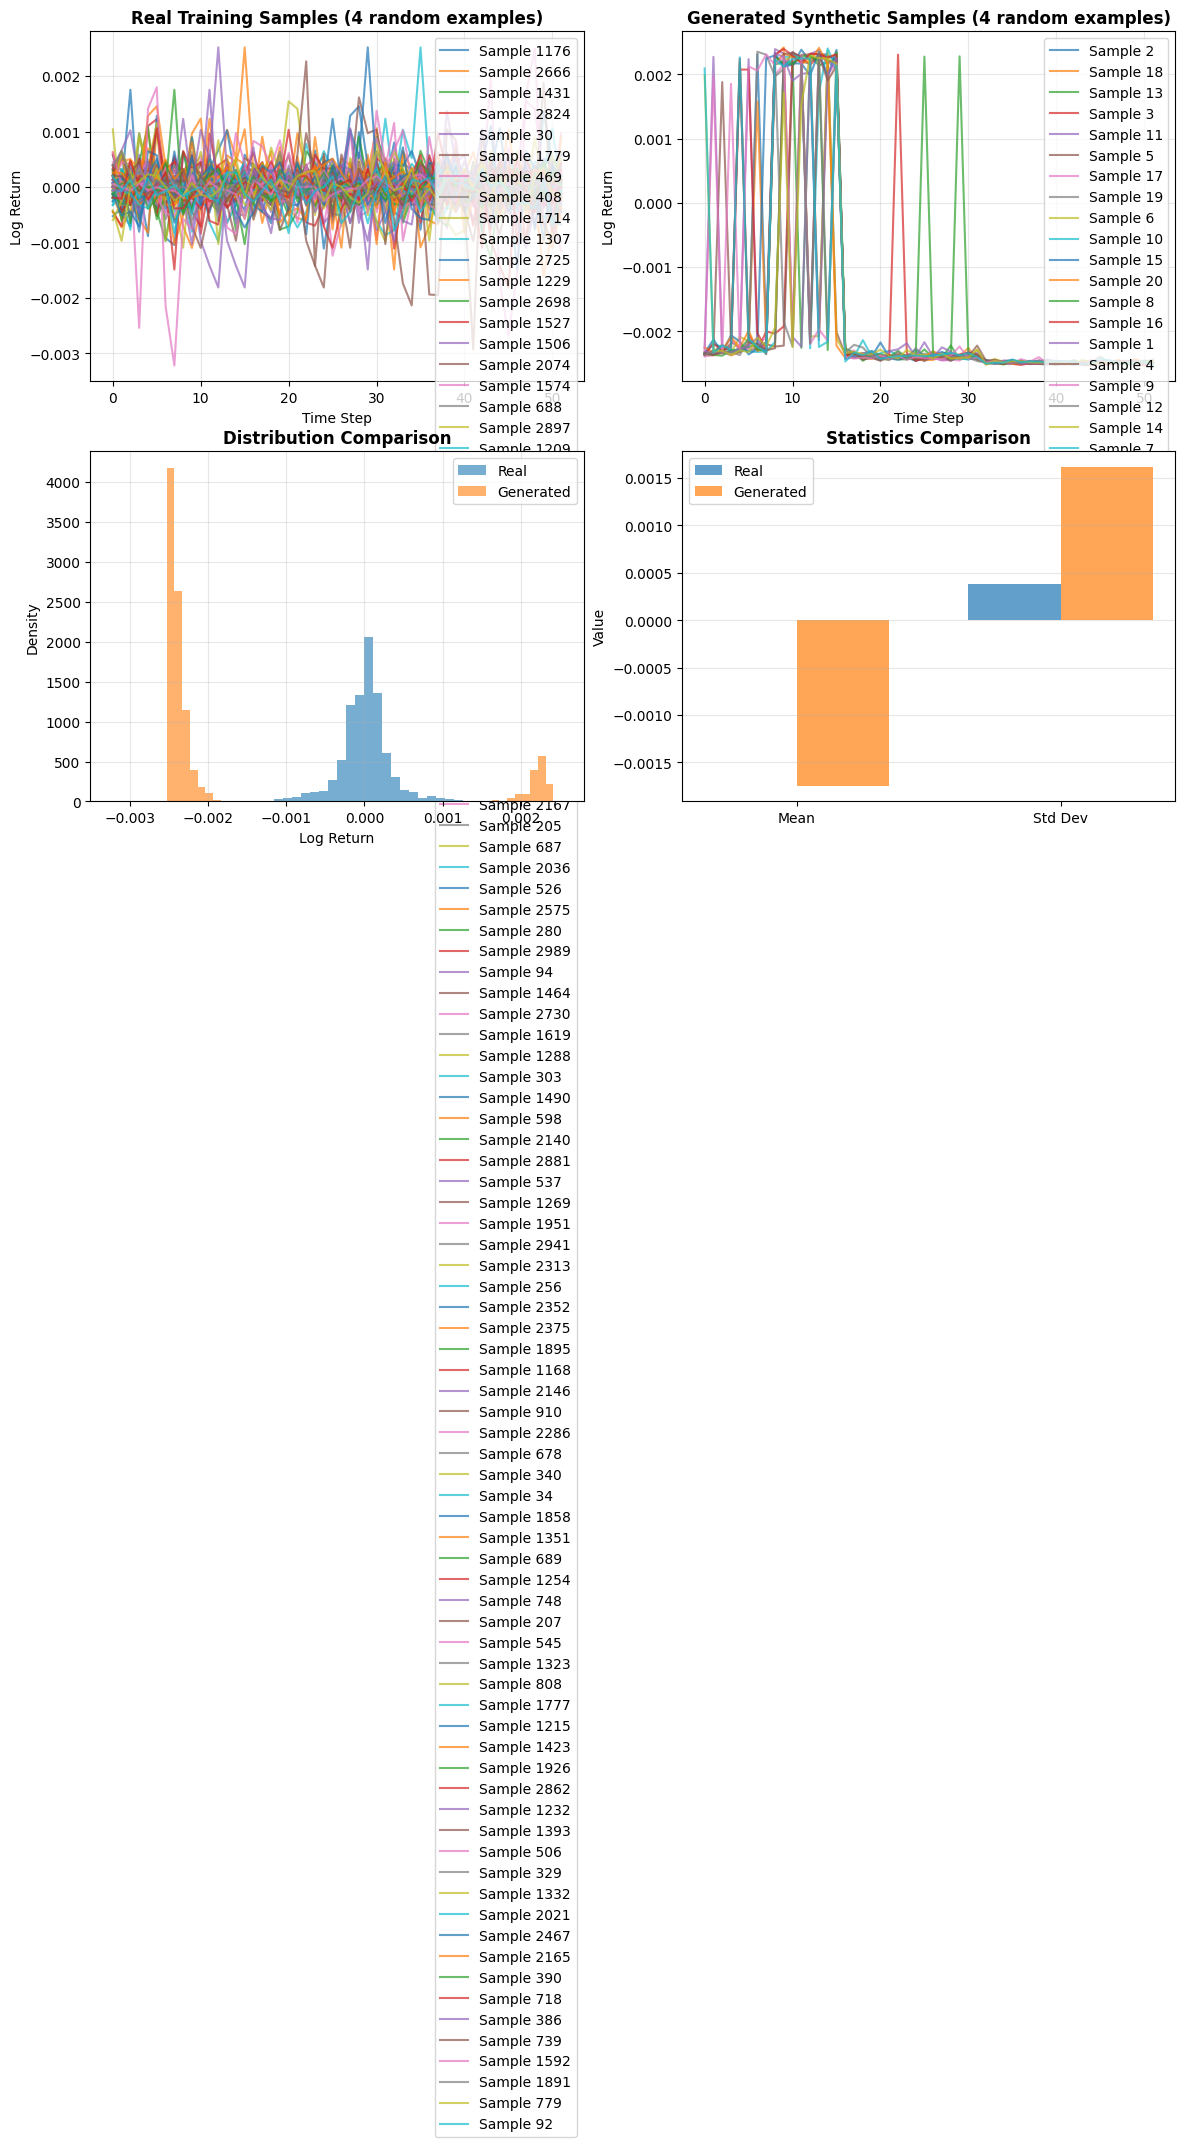


Statistics Summary:
Real data - Mean: -0.000000, Std: 0.000379
Generated - Mean: -0.001746, Std: 0.001613


In [ ]:
# Visualize generated vs real samples
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

import random

# Plot 1: Real training samples (randomly select 4 unique samples)
axes[0, 0].set_title('Real Training Samples (4 random examples)', fontsize=12, fontweight='bold')
num_real_examples = min(100, len(train_data))
if len(train_data) > 0:
    random_real_idxs = random.sample(range(len(train_data)), num_real_examples)
    for idx, real_idx in enumerate(random_real_idxs):
        axes[0, 0].plot(train_data[real_idx].numpy(), alpha=0.7, label=f'Sample {real_idx+1}')
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('Log Return')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Generated samples (randomly select 4 unique samples)
axes[0, 1].set_title('Generated Synthetic Samples (4 random examples)', fontsize=12, fontweight='bold')
num_gen_examples = min(100, num_samples)
if num_samples > 0:
    random_gen_idxs = random.sample(range(num_samples), num_gen_examples)
    for idx, gen_idx in enumerate(random_gen_idxs):
        axes[0, 1].plot(generated_samples[gen_idx].numpy(), alpha=0.7, label=f'Sample {gen_idx+1}')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('Log Return')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Distribution comparison
axes[1, 0].set_title('Distribution Comparison', fontsize=12, fontweight='bold')
axes[1, 0].hist(train_data.flatten().numpy(), bins=50, alpha=0.6, label='Real', density=True)
axes[1, 0].hist(generated_samples.flatten().numpy(), bins=50, alpha=0.6, label='Generated', density=True)
axes[1, 0].set_xlabel('Log Return')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Statistics comparison
axes[1, 1].set_title('Statistics Comparison', fontsize=12, fontweight='bold')
real_mean = train_data.mean().item()
real_std = train_data.std().item()
gen_mean = generated_samples.mean().item()
gen_std = generated_samples.std().item()

categories = ['Mean', 'Std Dev']
real_stats = [real_mean, real_std]
gen_stats = [gen_mean, gen_std]

x = np.arange(len(categories))
width = 0.35

axes[1, 1].bar(x - width/2, real_stats, width, label='Real', alpha=0.7)
axes[1, 1].bar(x + width/2, gen_stats, width, label='Generated', alpha=0.7)
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(categories)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nStatistics Summary:")
print(f"Real data - Mean: {real_mean:.6f}, Std: {real_std:.6f}")
print(f"Generated - Mean: {gen_mean:.6f}, Std: {gen_std:.6f}")


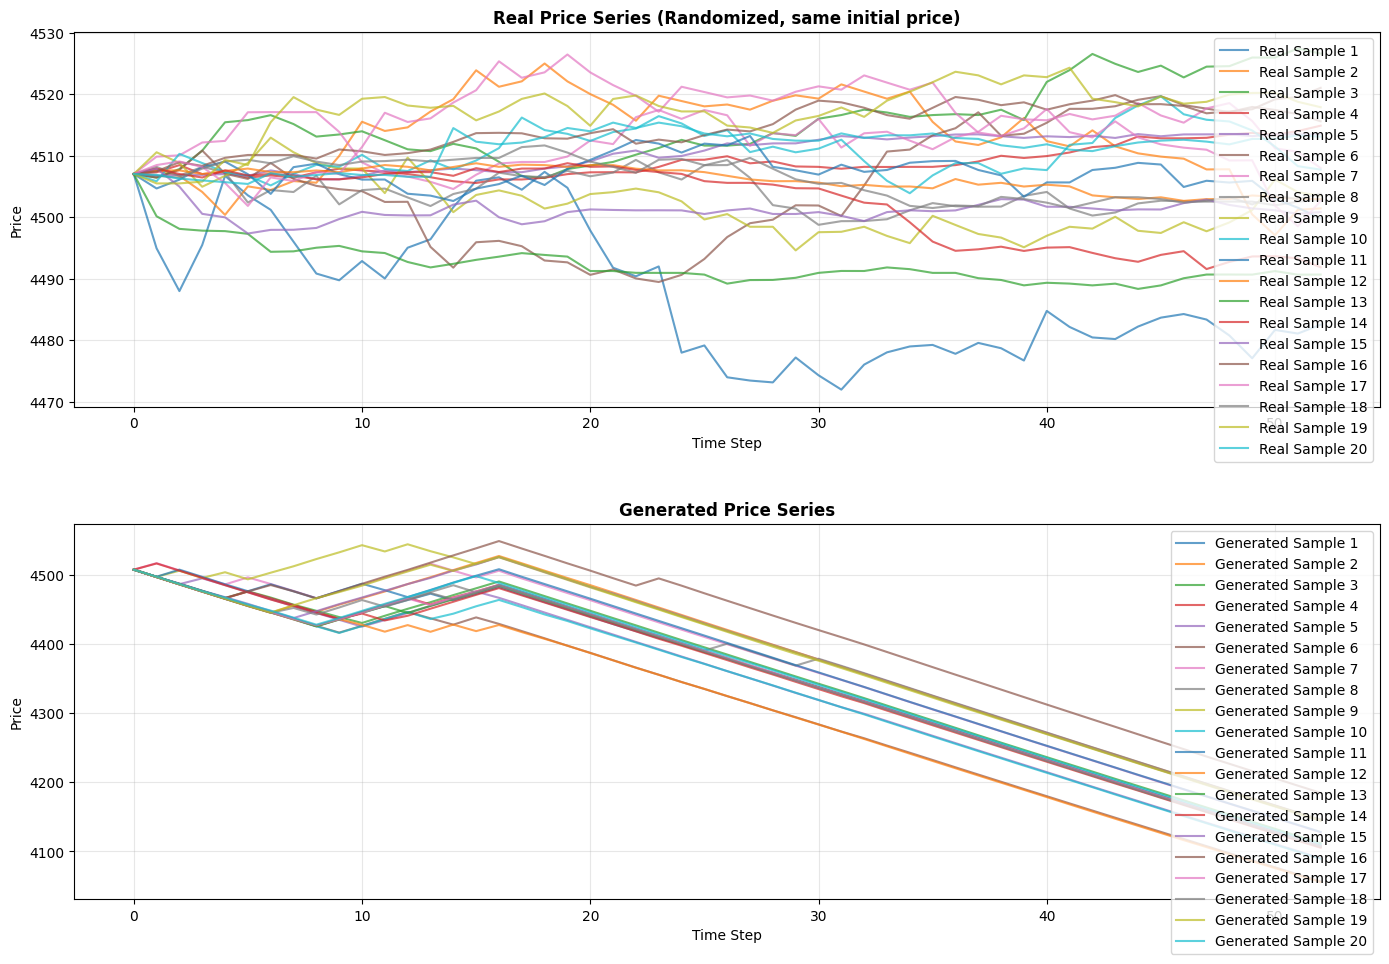


Successfully generated synthetic time series data using QuantGAN!

Note: QuantGAN uses Temporal Convolutional Networks (TCN) with WGAN-style training
for generating synthetic time series from log returns data.


In [ ]:
# Import LogReturnTransformation for converting log returns back to prices
from src.utils.preprocessing_utils import LogReturnTransformation

# Choose a single initial price to use for all samples
common_initial_idx = torch.randint(0, len(train_initial), (1,))
common_initial_price = train_initial[common_initial_idx].item()

# Convert generated log returns back to prices using the same initial price
scaler = LogReturnTransformation()
generated_prices_list = []
for i in range(num_samples):
    prices = scaler.inverse_transform(generated_samples[i], torch.tensor(common_initial_price))
    generated_prices_list.append(prices)

if len(train_data) > 0:
    real_indices = torch.randperm(len(train_data))[:num_samples]
else:
    real_indices = []

# Visualize price series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Real price series (reconstructed from random training samples, using the same initial price as generated samples)
axes[0].set_title('Real Price Series (Randomized, same initial price)', fontsize=12, fontweight='bold')
for idx, i in enumerate(real_indices):
    prices = scaler.inverse_transform(train_data[i], torch.tensor(common_initial_price))
    axes[0].plot(prices.numpy(), alpha=0.7, label=f'Real Sample {idx+1}')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Generated price series
axes[1].set_title('Generated Price Series', fontsize=12, fontweight='bold')
for i, prices in enumerate(generated_prices_list):
    axes[1].plot(prices.numpy(), alpha=0.7, label=f'Generated Sample {i+1}')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSuccessfully generated synthetic time series data using QuantGAN!")
print("\nNote: QuantGAN uses Temporal Convolutional Networks (TCN) with WGAN-style training")
print("for generating synthetic time series from log returns data.")
